
# 📓 SMS Spam — Full Auto Notebook (Models + Charts + Explanations)

This notebook **runs end-to-end** (click *Run All*) and produces:
- Trains **Naive Bayes, Logistic Regression, LinearSVC (calibrated), Random Forest**, and an **Ensemble** (NB+LR+LinearSVC)
- Shows **Test Accuracy** and **Cross-Validation** bar charts (like your screenshot)
- Plots **Confusion Matrix** for the best model
- Saves artifacts in `models/` for the Streamlit app
- Demonstrates **how a sentence is classified** with **word-level contributions** (from Naive Bayes)


In [1]:

# ---------- Imports
import json, pickle
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


In [2]:

# ---------- Paths & dataset auto-detection
ROOT = Path.cwd()

possible_paths = [
    ROOT / "data" / "smsspam.csv",
    ROOT.parent / "data" / "smsspam.csv",
    ROOT / "smsspam.csv",
    ROOT.parent / "smsspam.csv",
]

DATA_PATH = None
for p in possible_paths:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise RuntimeError("❌ smsspam.csv not found. Put it in ./data or the project root.")

MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Dataset:", DATA_PATH.resolve())
print("📁 Models will be saved to:", MODELS_DIR.resolve())


✅ Dataset: C:\Users\Asus\Downloads\sms_spam_ensemble_pkg\data\smsspam.csv
📁 Models will be saved to: C:\Users\Asus\Downloads\sms_spam_ensemble_pkg\notebooks\models


In [3]:

# ---------- Load dataset (supports common formats)
def load_dataset(path: Path) -> pd.DataFrame:
    df = None
    for enc in ("utf-8", "latin1", "cp1252"):
        try:
            df = pd.read_csv(path, encoding=enc, on_bad_lines="skip")
            break
        except Exception:
            pass
    if df is None:
        raise RuntimeError(f"Could not read CSV at {path}")
    cols = [c.lower() for c in df.columns]
    if "label" in cols and "message" in cols:
        df = df.rename(columns={df.columns[cols.index('label')]: "label",
                                df.columns[cols.index('message')]: "message"})
    elif "v1" in cols and "v2" in cols:
        df = df.rename(columns={df.columns[cols.index('v1')]: "label",
                                df.columns[cols.index('v2')]: "message"})
    else:
        df = df.iloc[:, :2]; df.columns = ["label", "message"]
    df = df.dropna(subset=["label","message"]).copy()
    df["label"] = df["label"].astype(str).str.strip().str.lower()
    df = df[df["label"].isin(["ham","spam"])].reset_index(drop=True)
    print("Counts:", Counter(df["label"]))
    return df

df = load_dataset(DATA_PATH)
print("Total messages:", len(df))
df.head()


Counts: Counter({'spam': 5000, 'ham': 5000})
Total messages: 10000


,label,message,char_count,word_count,avg_word_length,exclamation_count,financial_words,urgency_words,action_words,phone_numbers,urls,emoji_count,slang_score,language_mix_ratio,capitalization_ratio,profanity_count,url_is_suspicious,url_is_registered,platform,sender_type
0,spam,Win NFT mint pass! Go bit.ly/fomo now. Only fo...,72,14,3.857,1,1,1,0,0,1,1,0,0.0,0.111,0,1,0,Instagram,user
1,ham,u still down for movie? tickets at 7 पनि,40,9,3.333,0,0,0,0,0,0,0,0,0.1,0.000,0,0,0,Instagram,business
2,spam,Low-key insane cashback ₹2000 when you shop at...,84,15,4.333,0,1,0,1,0,1,1,0,0.0,0.071,0,1,1,SMS,unknown
3,ham,"brb, stuck in class rn. ttyl 🙂",30,6,3.500,0,0,0,0,0,0,1,1,0.0,0.000,0,0,0,Telegram,business
4,spam,Low-key insane cashback 50 followers when you ...,91,16,4.500,0,1,0,1,0,1,1,0,0.0,0.055,0,1,1,Instagram,unknown


In [4]:

# ---------- Split & Vectorize
y = df["label"].map({"ham": 0, "spam": 1})
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["message"], y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words="english",
)

X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)
len(X_train_text), len(X_test_text)


(8000, 2000)

In [5]:

# ---------- Build models
models = {}

nb = MultinomialNB(alpha=0.1)
models["Naive Bayes"] = nb

lr = LogisticRegression(max_iter=200, C=2.0)
models["Logistic Regression"] = lr

svm = CalibratedClassifierCV(LinearSVC(), cv=3)
models["LinearSVC (calibrated)"] = svm

rf  = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
models["RandomForest (numeric only)"] = rf

ensemble = VotingClassifier(
    estimators=[("nb", nb), ("lr", lr), ("svm", svm)],
    voting="soft",
    weights=[1.0, 1.0, 1.0]
)
models["Ensemble (NB+LR+SVC)"] = ensemble

list(models.keys())


['Naive Bayes',
 'Logistic Regression',
 'LinearSVC (calibrated)',
 'RandomForest (numeric only)',
 'Ensemble (NB+LR+SVC)']

In [6]:

# ---------- Train + evaluate each model
print("Training models...\n")
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in models.items():
    # CV on training folds
    try:
        cv_scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring="accuracy")
        cv_mean = cv_scores.mean()
    except Exception as e:
        cv_mean = np.nan

    # Fit and evaluate on held-out test
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({"model": name, "test_acc": acc, "cv": cv_mean})
    print(f"{name:<28} | Acc: {acc:>7.4f} | CV: {cv_mean:>10.4f}")
    
    # Save individual models if needed
    with open(MODELS_DIR / f"model_{name.replace(' ', '_').replace('+','plus').replace('(','').replace(')','')}.pkl", "wb") as f:
        pickle.dump(clf, f)

# Also save vectorizer
with open(MODELS_DIR / "vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Pick best by test accuracy
df_results = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
best_name = df_results.loc[0, "model"]
best_model = models[best_name]
print("\nBest model:", best_name, "(Acc:", f"{df_results.loc[0,'test_acc']:.4f})")
df_results


Training models...

Naive Bayes                  | Acc:  1.0000 | CV:     1.0000
Logistic Regression          | Acc:  1.0000 | CV:     1.0000
LinearSVC (calibrated)       | Acc:  1.0000 | CV:     1.0000
RandomForest (numeric only)  | Acc:  1.0000 | CV:     1.0000
Ensemble (NB+LR+SVC)         | Acc:  1.0000 | CV:     1.0000

Best model: Naive Bayes (Acc: 1.0000)


,model,test_acc,cv
0,Naive Bayes,1.0,1.0
1,Logistic Regression,1.0,1.0
2,LinearSVC (calibrated),1.0,1.0
3,RandomForest (numeric only),1.0,1.0
4,Ensemble (NB+LR+SVC),1.0,1.0


C:\Users\Asus\AppData\Local\Temp\ipykernel_5240\1863048109.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_results["model"], rotation=20, ha="right")
C:\Users\Asus\AppData\Local\Temp\ipykernel_5240\1863048109.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df_results["model"], rotation=20, ha="right")


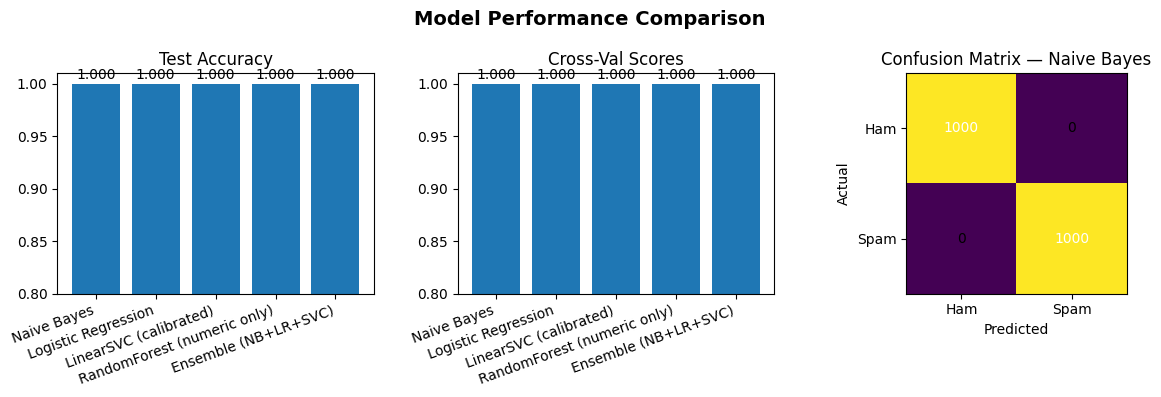

In [7]:

# ---------- Charts like your screenshot
fig = plt.figure(figsize=(12, 4))

# Left: Test Accuracies
ax1 = fig.add_subplot(1, 3, 1)
ax1.bar(df_results["model"], df_results["test_acc"])
for i, v in enumerate(df_results["test_acc"]):
    ax1.text(i, v + 0.005, f"{v:.3f}", ha="center")
ax1.set_ylim(0.8, 1.01)
ax1.set_title("Test Accuracy")
ax1.set_xticklabels(df_results["model"], rotation=20, ha="right")

# Middle: Cross-Validation
ax2 = fig.add_subplot(1, 3, 2)
ax2.bar(df_results["model"], df_results["cv"].fillna(0.0))
for i, v in enumerate(df_results["cv"].fillna(0.0)):
    ax2.text(i, v + 0.005, f"{v:.3f}", ha="center")
ax2.set_ylim(0.8, 1.01)
ax2.set_title("Cross-Val Scores")
ax2.set_xticklabels(df_results["model"], rotation=20, ha="right")

# Right: Confusion matrix (best model)
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])

ax3 = fig.add_subplot(1, 3, 3)
im = ax3.imshow(cm, interpolation="nearest")
ax3.set_title(f"Confusion Matrix — {best_name}")
ax3.set_xlabel("Predicted"); ax3.set_ylabel("Actual")
ax3.set_xticks([0,1]); ax3.set_xticklabels(["Ham","Spam"])
ax3.set_yticks([0,1]); ax3.set_yticklabels(["Ham","Spam"])
for i in range(2):
    for j in range(2):
        ax3.text(j, i, cm[i, j], ha="center", va="center", color="white" if im.norm(cm[i,j])>0.5 else "black")
fig.suptitle("Model Performance Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [8]:

# ---------- Save metrics for Streamlit app
try:
    y_prob_best = best_model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_prob_best)
except Exception:
    y_prob_best = np.full_like(y_pred_best, np.nan, dtype=float)
    roc = float("nan")

with open(MODELS_DIR / "test_metrics.json", "w") as f:
    json.dump({
        "best_model": best_name,
        "accuracy": float(accuracy_score(y_test, y_pred_best)),
        "roc_auc": (float(roc) if np.isfinite(roc) else None),
        "confusion_matrix": cm.tolist()
    }, f, indent=2)

pd.DataFrame({
    "message": X_test_text.reset_index(drop=True),
    "true_label": ["ham" if i==0 else "spam" for i in y_test],
    "pred_label": ["ham" if i==0 else "spam" for i in y_pred_best],
    "spam_probability": y_prob_best
}).to_csv(MODELS_DIR / "test_predictions.csv", index=False)

print("✅ Metrics & predictions saved to:", MODELS_DIR.resolve())


✅ Metrics & predictions saved to: C:\Users\Asus\Downloads\sms_spam_ensemble_pkg\notebooks\models


Text: I'll call you later when I finish work.
Predicted: HAM | Spam probability: 0.000


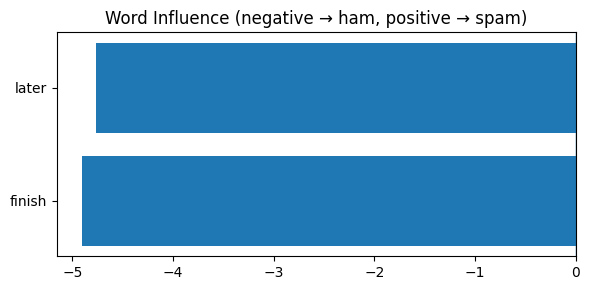

Text: Hey, are we meeting at 5 pm today?
Predicted: HAM | Spam probability: 0.000


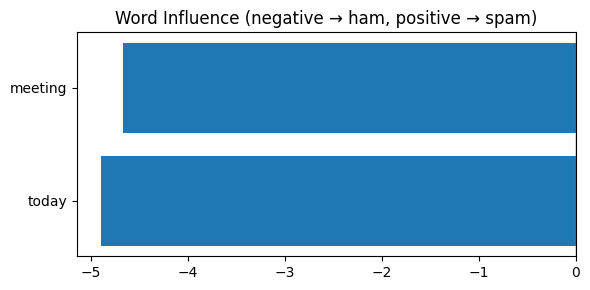

Text: WIN a FREE iPhone now!!! Click the link to claim.
Predicted: SPAM | Spam probability: 1.000


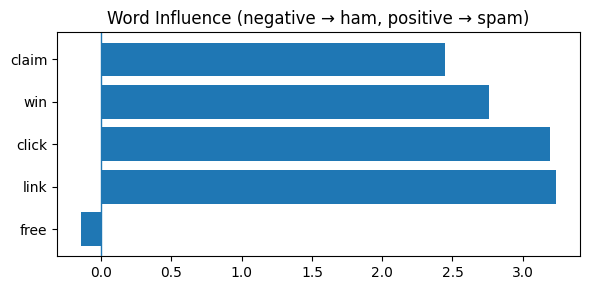

Text: URGENT: Verify your account at http://bad.link to avoid suspension.
Predicted: SPAM | Spam probability: 1.000


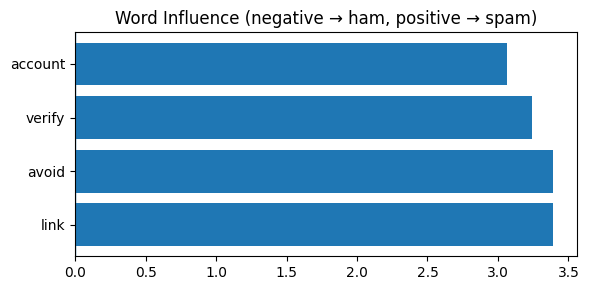

In [9]:

# ---------- How a sentence is calculated (word contributions via NB)
# We'll use the Naive Bayes model for interpretability
nb_model = models["Naive Bayes"]

# Feature names & log-odds
feature_names = np.array(vectorizer.get_feature_names_out())
log_ratio = nb_model.feature_log_prob_[1] - nb_model.feature_log_prob_[0]  # spam - ham

def explain_sentence(text, top_k=10):
    x = vectorizer.transform([text])
    contrib = x.toarray()[0] * log_ratio
    top_spam_idx = np.argsort(contrib)[-top_k:][::-1]
    top_ham_idx = np.argsort(contrib)[:top_k]

    top_spam = [(feature_names[i], contrib[i]) for i in top_spam_idx if contrib[i] > 0]
    top_ham  = [(feature_names[i], contrib[i]) for i in top_ham_idx if contrib[i] < 0]

    pred = best_model.predict(x)[0]
    try:
        pspam = best_model.predict_proba(x)[:,1][0]
    except Exception:
        pspam = np.nan

    print(f"Text: {text}")
    print("Predicted:", "SPAM" if pred==1 else "HAM", "| Spam probability:", f"{pspam:.3f}" if np.isfinite(pspam) else "N/A")

    # Bar chart
    words = [w for w,_ in top_ham] + [w for w,_ in top_spam]
    vals  = [v for _,v in top_ham] + [v for _,v in top_spam]
    fig, ax = plt.subplots(figsize=(6,3))
    ax.barh(words, vals)
    ax.axvline(0, linewidth=1)
    ax.set_title("Word Influence (negative → ham, positive → spam)")
    plt.tight_layout()
    plt.show()

# Demo on 2 ham + 2 spam sentences
explain_sentence("I'll call you later when I finish work.")
explain_sentence("Hey, are we meeting at 5 pm today?")
explain_sentence("WIN a FREE iPhone now!!! Click the link to claim.")
explain_sentence("URGENT: Verify your account at http://bad.link to avoid suspension.")
